# Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

dir = '/content/drive/MyDrive/NMA 2021/Project Brownies/'

Mounted at /content/drive


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from sklearn import linear_model, metrics

In [ ]:
#load the dataset
fname = "kay_labels.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/r638s/download
fname = "kay_labels_val.npy"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/yqb3e/download
fname = "kay_images.npz"
if not os.path.exists(fname):
  !wget -qO $fname https://osf.io/ymnjv/download

# Load Dataset

`dat` has the following fields:  
- `stimuli`: stim x i x j array of grayscale stimulus images (1750 x 128 x 128)
- `stimuli_test`: stim x i x j array of grayscale stimulus images in the test set (120 x 128 x 128)
- `responses`: stim x voxel array of z-scored BOLD response amplitude (1750 x 8428)
- `responses_test`:  stim x voxel array of z-scored BOLD response amplitude in the test set (120 x 8428) 
- `roi`: array of voxel labels (8428,)
- `roi_names`: array of names corresponding to voxel labels (8,)

In [ ]:
with np.load(fname) as dobj:
    dat = dict(**dobj)
# preprocess the image
preprocess = transforms.Compose([
     transforms.ToTensor(),
     transforms.Resize(224),

     # for hypothesis 2
     #transforms.RandomRotation(degrees=(0, 180)), 
     #transforms.RandomHorizontalFlip(p=1),
     #transforms.RandomVerticalFlip(p=1),
     
     # normalize to imagenet stats
     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),    
])

stimuli = np.repeat(dat["stimuli"][:,:,:,np.newaxis], 3, -1)
preped_stimuli = torch.empty(size=(stimuli.shape[0],3,224,224))
for ii in range(0,stimuli.shape[0]):
  preped_stimuli[ii,:,:,:] = preprocess((stimuli[ii,:,:,:]+1)/2)

stimuli_test = np.repeat(dat["stimuli_test"][:,:,:,np.newaxis], 3, -1)
preped_stimuli_test = torch.empty(size=(stimuli_test.shape[0],3,224,224))
for ii in range(0,stimuli_test.shape[0]):
  preped_stimuli_test[ii,:,:,:] = preprocess((stimuli_test[ii,:,:,:]+1)/2)

In [ ]:
y = dat["responses"]
y_test = dat["responses_test"]

roi = dat["roi"]
roi_names = dat["roi_names"]
print(roi_names)
roi_idx, roi_nvox = np.unique(roi, return_counts=True)
print(roi_idx)
print(roi_nvox)

['Other' 'V1' 'V2' 'V3' 'V3A' 'V3B' 'V4' 'LatOcc']
[1 2 3 4 5 6 7]
[1294 2083 1790  484  314 1535  928]


### VIsualize Images

In [ ]:
#rotation_stim = preped_stimuli
#horizontalflip_stim = preped_stimuli
verticalflip_stim= preped_stimuli

In [ ]:
# Example images of spatial transformation
f, axs = plt.subplots(1, 4, figsize=(12, 6), sharex=True, sharey=True)
for ax, im, lbl in zip(axs.flat, [dat["stimuli"][0], rotation_stim[0].permute(1,2,0), horizontalflip_stim[0].permute(1,2,0),verticalflip_stim[0].permute(1,2,0)], ['Original', 'Rotation', 'Horizontal Reflection', 'Vertical Reflection']):
  ax.imshow(im, cmap="gray")
  ax.set_title(lbl)
f.tight_layout()
f.savefig(dir+'example images of spatial transf.png')

# Hypothesis 1 : Linear encoding model predicting neural responses from layers of the DNN model

## 1. Extract Features of layers of the DNN model

In [ ]:
# Extract features (activations) of layers for each image
def extract_feat(self, x):
  self = self.eval()
  out1 = self.features[0:3](x)
  out2 = self.features[3:6](out1)
  out3 = self.features[6:8](out2)
  out4 = self.features[8:10](out3)
  out5 = self.features[10:13](out4)

  out5_reshaped = out5.view(out5.size(0), 256 * 6 * 6)
  out6 = self.classifier[0:3](out5_reshaped)
  out7 = self.classifier[3:6](out6)
  out8 = self.classifier[6:7](out7)

  features = np.empty((1,8),dtype=object)
  for i, out in enumerate([out1, out2, out3, out4, out5, out6, out7, out8]):
    feat = out.detach().numpy()
    features[0,i] = feat.reshape(feat.shape[0],np.prod(feat.shape[1:]))  # put all units into single vector for each layer

  return features

In [ ]:
# DNN model

# pretrained AlexNet
#net = models.alexnet(pretrained=True)

# untrained AlexNet (null model)
net = models.alexnet(pretrained=False)

In [ ]:
# extract features
features_train= extract_feat(net, preped_stimuli)
features_test = extract_feat(net, preped_stimuli_test)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [ ]:
# Save features
np.save(dir+'features_untrained_train.npy', features_train)
np.save(dir+'features_untrained_test.npy', features_test)

In [ ]:
# Load features
tmp=np.load(dir+'features_test.npy', allow_pickle=True)

## 2. Predict neural responses of brain regions from features of all layers

In [ ]:
# Error metric
def MSE(elem1, elem2):
  t_sum = np.sum((elem1-elem2)**2)
  return t_sum/(elem1.shape[0]*elem1.shape[1])    # samples x voxels
  #return ((elem1-elem2)**2).mean(axis=None)

def dist_euclidean(elem1, elem2):
  t_sum = np.sum((elem1-elem2)**2)
  return np.sqrt(t_sum)

In [ ]:
# Linear model
LR = linear_model.Lasso(alpha = 0.1)

err = np.ones([7,8])
for i in range(0,8):   # layers of the model(7)
 # for lambda in range(0,10,10)
  for iroi in range(1,8):    # regions of the brain(8)
    train_y = y[:,roi==iroi]
    test_y = y_test[:,roi==iroi] 
    LR.fit(features_train[0,i],train_y)
    y_prediction =  LR.predict(features_test[0,i])
    print('layer {0}, ROI {1}, Prediction {2}'. format(i+1, iroi, y_prediction.shape))
    #err[iroi-1,i] = dist_euclidean(y_prediction, test_y)
    err[iroi-1,i] = MSE(test_y, y_prediction)    # MSE values of layers by regions
    #err[iroi-1,i] = metrics.r2_score(test_y, y_prediction)

# save error results
np.save(dir+'linreg_mse_untrained.npy', err)

In [ ]:
# load error results
err_tmp=np.load(dir+'linreg_mse_norm.npy')

In [ ]:
#plot the MSE for each ROI

[[0.85513562 0.66930918 0.65150879 0.68238934 0.99726123 2.86389906
  5.57355797 1.66258316]
 [0.87081947 0.67107364 0.65378665 0.6874946  1.00030621 2.94226431
  5.63530314 1.7185648 ]
 [0.87126218 0.66180368 0.64305519 0.67799649 1.0006373  2.966371
  5.68769544 1.73594411]
 [0.89420011 0.6747633  0.65799154 0.68996706 1.0033458  2.95705313
  5.83574436 1.80770214]
 [0.87784687 0.67295076 0.65955084 0.69429205 1.02041966 2.98692034
  5.74789901 1.77844597]
 [0.87718062 0.66823559 0.65218224 0.68278023 1.01076202 2.98708219
  5.7194019  1.72475436]
 [0.88257387 0.67797092 0.65681902 0.68696126 1.01667552 3.02719069
  5.73864062 1.78018568]]


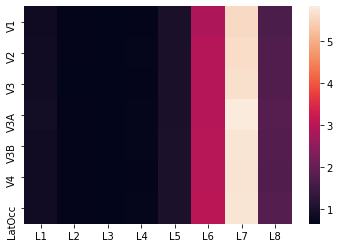

In [ ]:
# visualize prediction error with heatmap
print(err)

import seaborn as sns
ax=sns.heatmap(err, xticklabels=list('L'+str(i) for i in range(1,9)), yticklabels=roi_names[1:])
#f.savefig('heatmap_linreg_mse_norm.png')

In [ ]:
# LR for each voxel
LR = linear_model.LinearRegression()
err = np.zeros([7,8])
for i in range(0,8):
  features = net.features[:0](preped_stimuli).numpy().reshape(preped_stimuli.shape[0],np.prod(preped_stimuli.shape[1:]))
  features_test = net.features[:0](preped_stimuli_test).numpy().reshape(preped_stimuli_test.shape[0],np.prod(preped_stimuli_test.shape[1:]))
  for iroi in range(1,8):
    voxel_idx = np.array(np.where(roi==iroi))
    for ivoxel in range(0,np.sum(roi==iroi)):
      train_y = y[:,voxel_idx[0,ivoxel]]
      test_y = y_test[:,voxel_idx[0,ivoxel]] 
      LR.fit(features,train_y)
      y_prediction =  LR.predict(features_test)
      err[iroi,i] = err[iroi,i] + np.linalg.norm(y_prediction - test_y)
    err[iroi,i] = err[iroi,i]/np.sum(roi==iroi)

# Hypothesis 2 : Feature representations of layers of the DNN model and regions of the visual cortex

## 1. Sort fMRI responses by the labels of images

In [ ]:
# Change string labels to number labels
labels = np.load('kay_labels.npy')
val_labels = np.load('kay_labels_val.npy')

labels_idx=0   # 0:highest wordnet hierarchy, 3: imagenet labels

# Train data
train_labels = []
labeltypes1, types_count1 = np.unique(labels[labels_idx,:], return_counts=True)
for ii in range(len(y)):
  train_labels.append(np.where(labeltypes1 == labels[labels_idx,ii])[0][0])
print('TRAIN | Number of label types: {0}, Number of images in each label type: {1}, Number of total labels: {2}' .format(labeltypes1.shape, types_count1, np.shape(train_labels)))

#Test data
test_labels = []
labeltypes2, types_count2 = np.unique(val_labels[labels_idx,:], return_counts=True)
for ii in range(len(y_test)):
  test_labels.append(np.where(labeltypes2 == val_labels[labels_idx,ii])[0][0])
print('TEST  | Number of label types: {0}, Number of images in each label type: {1}, Number of total labels: {2}' .format(labeltypes2.shape, types_count2, np.shape(train_labels)))

TRAIN | Number of label types: (8,), Number of images in each label type: [589 812  72  77   5 192   2   1], Number of total labels: (1750,)
TEST  | Number of label types: (6,), Number of images in each label type: [54 50  4  1  1 10], Number of total labels: (1750,)


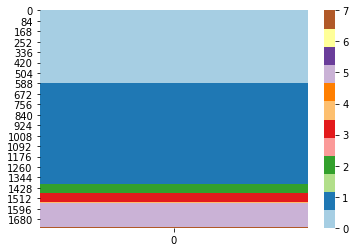

In [ ]:
# image labels
# Label0 : animal 0, artifact 1, others -1
sort_idx = np.argsort(train_labels)
train_labels_sorted=np.sort(train_labels)

#for i in range(len(train_labels_sorted)):
#  if train_labels_sorted[i] != 0 and train_labels_sorted[i] !=1:train_labels_sorted[i]=-1

import seaborn as sns
ax= sns.heatmap(np.expand_dims(train_labels_sorted, axis=1), cmap="Paired")

In [ ]:
# sort fmri responses by image labels
sort_idx = np.argsort(train_labels)   # index from lowest to highest
y_sorted = y[sort_idx,:]
print(y_sorted.shape)

(1750, 8428)


In [ ]:
# try without sorting
y_sorted = y   

## 2. Compute RDM

In [ ]:
# Compute RDM of neural responses
RDM = np.empty((1,7),dtype=object)
for iroi in range(1,8):    # for each region(7)
  response = y_sorted[:,roi==iroi]
  print('ROI', iroi, response.shape)
  rdm_size = response.shape[0]
  RDM[0,iroi-1] = np.zeros([rdm_size,rdm_size])
  for i in range(rdm_size):
    for j in range(rdm_size):
      RDM[0,iroi-1][i,j] = 1-np.corrcoef(response[i,:], response[j,:])[0,1]   # 1- correlation coefficient (0 ~ 2)
      # RDM[0,iroi-1][i,j] = np.linalg.norm(response[i,:]-response[j,:])   # euclidian distance

RDM_fmri = RDM

np.save(dir+'RDM_fmri_unsorted_corr.npy', RDM_fmri)

ROI 1 (1750, 1294)
ROI 2 (1750, 2083)
ROI 3 (1750, 1790)
ROI 4 (1750, 484)
ROI 5 (1750, 314)
ROI 6 (1750, 1535)
ROI 7 (1750, 928)


In [ ]:
# Compute RDM of features of layers

# Read extracted features
feat_loaded=np.load(dir+'features_untrained_train.npy', allow_pickle=True)

RDM = np.empty((1,8),dtype=object)
for L in range(0,8):    # for each layer(8)
  sig = feat_loaded[0,L]
  print('Layer', L+1, sig.shape)
  rdm_size=sig.shape[0]
  RDM[0,L] = np.zeros([rdm_size,rdm_size])
  for i in range(rdm_size):
    for j in range(rdm_size):
      RDM[0,L][i,j] = 1-np.corrcoef(sig[i,:], sig[j,:])[0,1]   # 1- correlation coefficient (0 ~ 2)
      # RDM[0,L][i,j] = np.linalg.norm(sig[i,:]-sig[j,:])   # euclidian distance

RDM_layers = RDM

# Save RDM
np.save(dir+'RDM_layers_corr_untrained.npy', RDM_layers)

Layer 1 (1750, 46656)
Layer 2 (1750, 32448)
Layer 3 (1750, 64896)
Layer 4 (1750, 43264)
Layer 5 (1750, 9216)
Layer 6 (1750, 4096)
Layer 7 (1750, 4096)
Layer 8 (1750, 1000)


In [ ]:
# Read RDM
RDM_fmri = np.load(dir+'RDM_label0_corr.npy', allow_pickle=True)

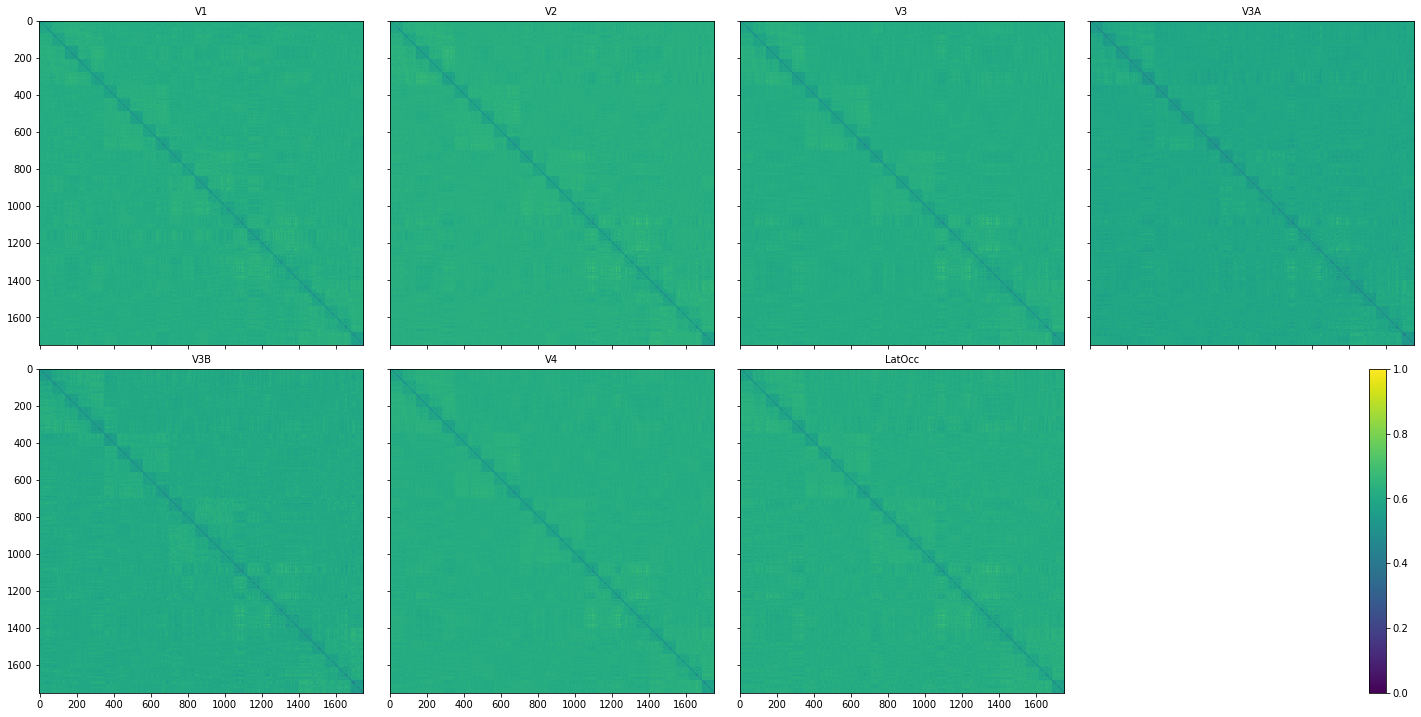

In [ ]:
# Visualize Dissimilarity Matrix : fmri
f, axs = plt.subplots(2,4, figsize=(20,10), sharex=True, sharey=True)
for ax, rdm, roi in zip(axs.flat, RDM_fmri[0], roi_names[1:]):
  ax.imshow(rdm)
  ax.set_title(roi, fontdict={'size': 10})

f.delaxes(axs[1, 3])
from matplotlib import cm
m = cm.ScalarMappable()
m.set_array([])
f.colorbar(m, ax=axs[1,3])

f.tight_layout()


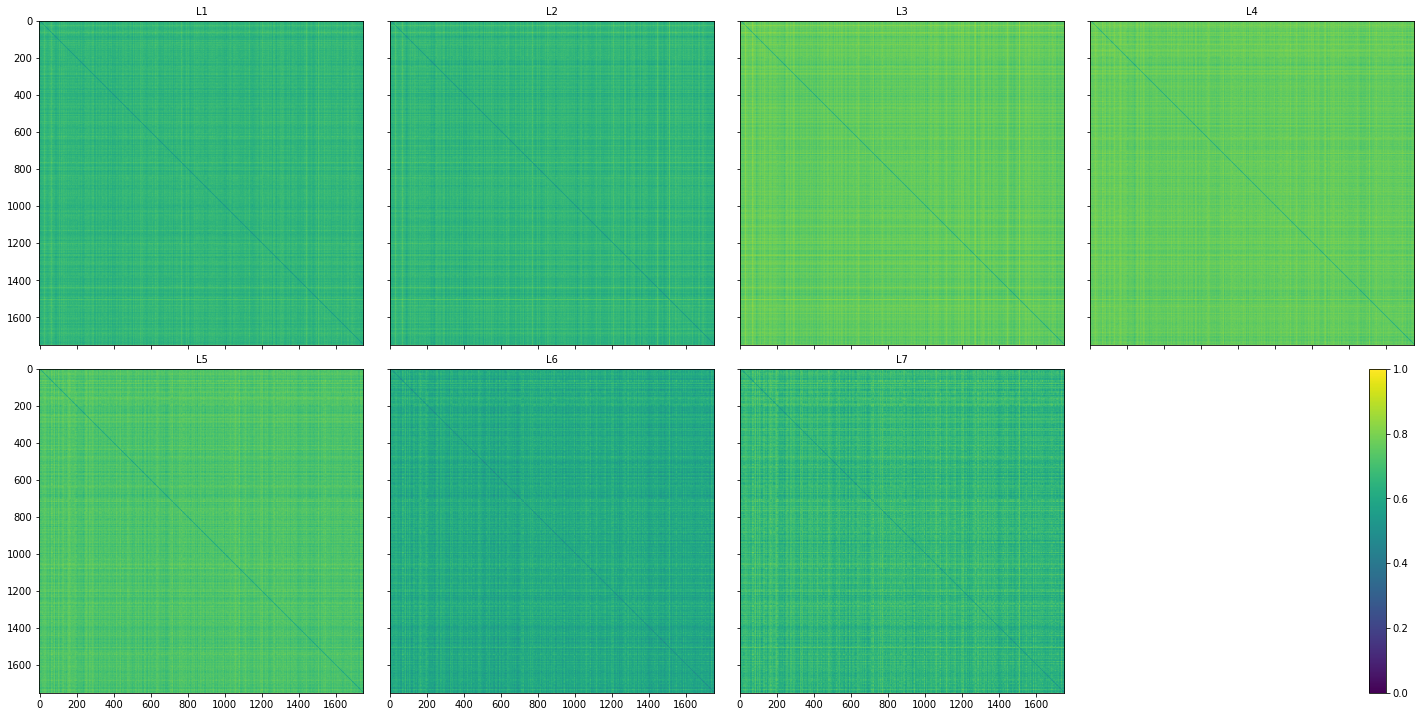

In [ ]:
# Visualize Dissimilarity Matrix : layers
f, axs = plt.subplots(2,4, figsize=(20,10), sharex=True, sharey=True)
for ax, rdm, layers in zip(axs.flat, RDM_layers[0], list('L'+str(i) for i in range(1,9))):
  ax.imshow(rdm)
  ax.set_title(layers, fontdict={'size': 10})

f.delaxes(axs[1, 3])
from matplotlib import cm
m = cm.ScalarMappable()
m.set_array([])
f.colorbar(m, ax=axs[1,3])

f.tight_layout()


## 3. Compute similarities between RDMs

In [ ]:
# Calculate similarity between RDMs

# Read RDMs
RDM_fmri = np.load(dir+'RDM_label0_corr.npy', allow_pickle=True)
RDM_layers = np.load(dir+'RDM_layers_corr_norm.npy', allow_pickle=True)

import scipy.stats as stats
r=np.empty((8,7))   # 8 layers x 7 rois
p=np.empty((8,7))

for i in range(len(RDM_layers[0])):
  for j in range(len(RDM_fmri[0])):
    # vectorize RDMs
    vec1 = RDM_layers[0,i][np.triu_indices(RDM_layers[0,i].shape[0], k = 1)]
    vec2 = RDM_fmri[0,j][np.triu_indices(RDM_fmri[0,j].shape[0], k = 1)]
    r[i, j], p[i, j] = stats.kendalltau(vec1, vec2)
    # stats.spearmanr

# boostrap

Text(0, 0.5, "Spearman's R")

<Figure size 432x288 with 0 Axes>

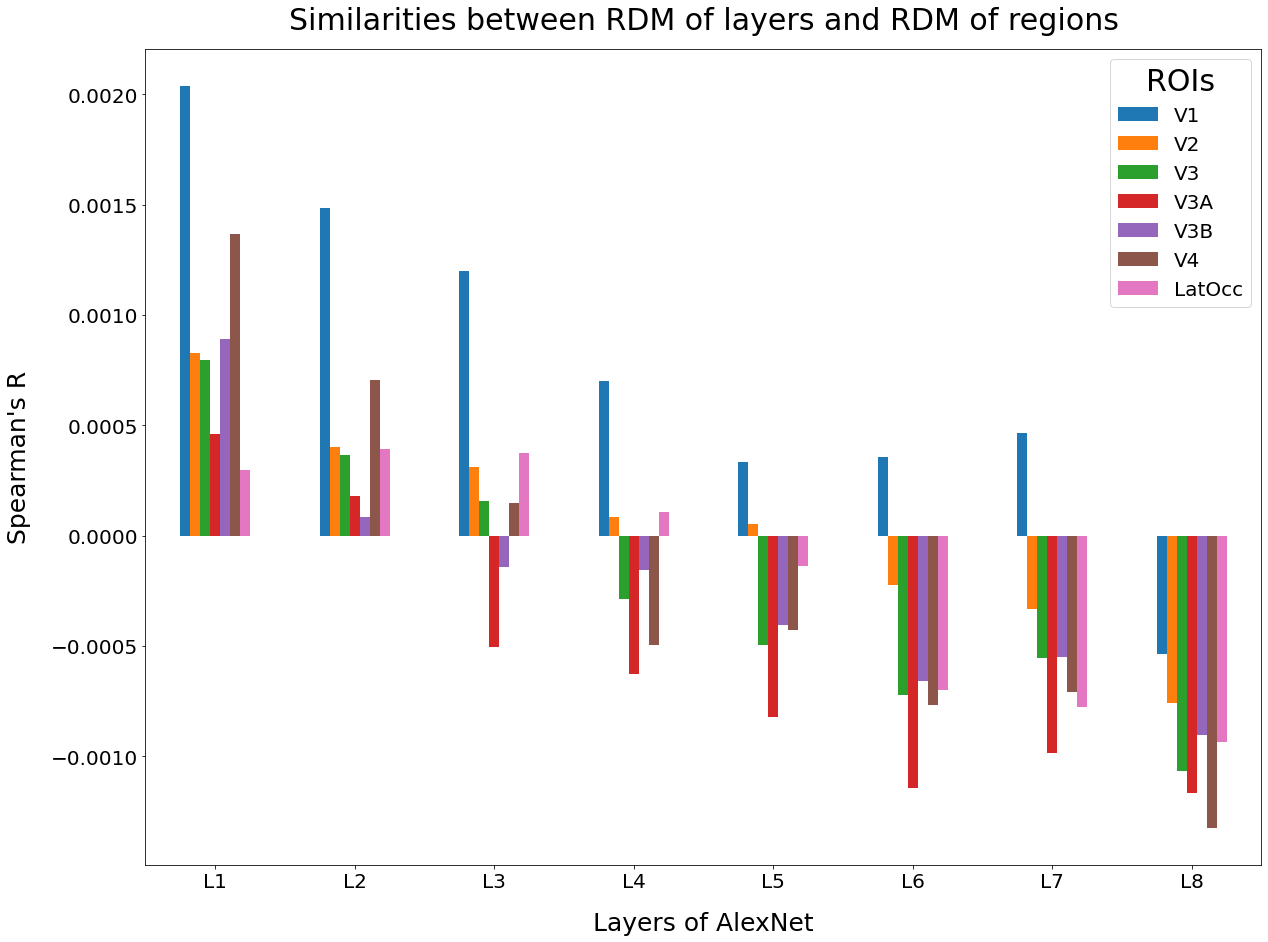

In [ ]:
# plot RDM similarities
import pandas as pd

layers=list('L'+str(i) for i in range(1,9))
df=pd.DataFrame(r, index=layers)

plt.figure()
#plt.rcParams.update({'font.size': 30})

# correlation
ax=df.plot.bar(fontsize=20, figsize=(20,15), rot=0)
ax.legend(roi_names[1:], fontsize=20, title='ROIs', prop={'size':20})
ax.set_title('Similarities between RDM of layers and RDM of regions', pad=20, fontdict={'fontsize': 30})
ax.set_xlabel('Layers of AlexNet', fontsize=25, labelpad=20)
ax.set_ylabel("Spearman's R", fontsize=25, labelpad=20)

# significance
#for coord, i, j in zip(ax.patches, p):
  #p[]
  #if sig < 0.05 : 
    #ax.annotate('*', (p.get_x() + p.get_width()/2., p.get_height()),
     #ha='center', va='center', color='gray')